# CosmoDC

### Goals
- How to interface QP and sacc
- How to create n(z) uncertainties from an ensemble of n(z)'s

### Requirements
- **A sacc file**: we will use the sacc file of Prat et al 2022 (2212.09345). This sacc file contains the summary statistics measured from the CosmoDC2 simulations using the DESC TXPipe pipeline. The summary statistics include the angular power spectra of the shear-shear, position-shear, and position-position correlations, as well as the cross-correlations between the different probes. The sacc file also contains the redshift distributions of the galaxies in the simulations. For more details see Prat et al 2022. The data can found in NERSC at '/global/cfs/cdirs/lsst/groups/WL/projects/star-challenge/gaussian/data_vectors'.

- **A series of QP ensenbles**: For this tutorials I have created a series of QP ensembles using the cosmoDC2_v1.1.4_image_with_photoz_v1 simulations. This catalog contains photometric redshifts that were computed with the `BPZ` template-based code (https://ui.adsabs.harvard.edu/abs/2000ApJ...536..571B/abstract) by Sam Schmidt. We use all the available pixels and impose a 24.1 magnitude cut in the i-band following Prat et al. The edges of the tomographic bins are also taken from Prat et al.

### Special Dependencies
- **sacc**: standard DESC library to load and save data.
- **nz_prior**: this very own library, used to compute n(z) uncertainties from n(z) ensembles.
- **PACC** is a plotting library (https://github.com/jaimerzpP/pacc) for sacc files.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qp
import sacc
import yaml
import scipy
import nz_prior as nzp
import h5py

plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18

In [2]:
method = "lognormal" #sompz, lognormal

if method == "sompz":
    f = h5py.File('/home/jaimerzp/Documents/UCL/nz_prior/examples/data/FIDUCIAL_DOUBLE_Y1.hdf5', 'r')
    z_fid = np.linspace(0, 3, 301)
    dz_fid = z_fid[1] - z_fid[0]
    z_fid_edges = z_fid - dz_fid / 2
    z_fid_edges = np.append(z_fid_edges, z_fid_edges[-1] + dz_fid / 2)
    source_0 = {}
    source_0["zgrid"] = z_fid_edges[0:101]
    source_0["znodes"] = z_fid[0:100]
    source_0["photo_hists"] = np.array(f["source"]["data"][:10000, 0, 0:100]).T
    source_1 = {}
    source_1["zgrid"] = z_fid_edges[0:101]
    source_1["znodes"] = z_fid[0:100]
    source_1["photo_hists"] = np.array(f["source"]["data"][:10000, 1, 0:100]).T
    source_2 = {}
    source_2["zgrid"] = z_fid_edges[20:121]
    source_2["znodes"] = z_fid[20:120]
    source_2["photo_hists"] = np.array(f["source"]["data"][:10000, 2, 20:120]).T
    source_3 = {}
    source_3["zgrid"] = z_fid_edges[40:141]
    source_3["znodes"] = z_fid[40:140]
    source_3["photo_hists"] = np.array(f["source"]["data"][:10000, 3, 40:140]).T
    source_4 = {}
    source_4["zgrid"] = z_fid_edges
    source_4["znodes"] = z_fid   
    source_4["photo_hists"] = np.array(f["source"]["data"][:10000, 4, :]).T
    lens_0 = {}
    lens_0["zgrid"] = z_fid_edges[13:51]
    lens_0["znodes"] = z_fid[13:50]
    lens_0["photo_hists"] = np.array(f["lens"]["data"][:10000, 0, 13:50]).T
    lens_1 = {}
    lens_1["zgrid"] = z_fid_edges[25:71]
    lens_1["znodes"] = z_fid[25:70]
    lens_1["photo_hists"] = np.array(f["lens"]["data"][:10000, 1, 25:70]).T
    lens_2 = {}
    lens_2["zgrid"] = z_fid_edges[50:91]
    lens_2["znodes"] = z_fid[50:90]
    lens_2["photo_hists"] = np.array(f["lens"]["data"][:10000, 2, 50:90]).T
    lens_3 = {}
    lens_3["zgrid"] = z_fid_edges[70:111]
    lens_3["znodes"] = z_fid[70:110]
    lens_3["photo_hists"] = np.array(f["lens"]["data"][:10000, 3, 70:110]).T
    lens_4 = {}
    lens_4["zgrid"] = z_fid_edges[80:141]
    lens_4["znodes"] = z_fid[80:140]
    lens_4["photo_hists"] = np.array(f["lens"]["data"][:10000, 4, 80:140]).T
else:
    source_0 = dict(np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_bpz_old/shear_0.npz"))
    source_1 = dict(np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_bpz_old/shear_1.npz"))
    source_2 = dict(np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_bpz_old/shear_2.npz"))
    source_3 = dict(np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_bpz_old/shear_3.npz"))
    source_4 = dict(np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_bpz_old/shear_4.npz"))
    lens_0 = dict(np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_bpz_old/lens_0.npz"))
    lens_1 = dict(np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_bpz_old/lens_1.npz"))
    lens_2 = dict(np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_bpz_old/lens_2.npz"))
    lens_3 = dict(np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_bpz_old/lens_3.npz"))
    lens_4 = dict(np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_bpz_old/lens_4.npz"))


### Load Data

In [3]:
# Sacc file
s = sacc.Sacc.load_fits("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc")
y = yaml.load(open("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/gcgc_gcwl_wlwl.yml"), Loader=yaml.FullLoader)

tomos = {'source_0': source_0,
        'source_1': source_1,
        'source_2': source_2,
        'source_3': source_3,
        'source_4': source_4,
        'lens_0': lens_0,
        'lens_1': lens_1,
        'lens_2': lens_2,
        'lens_3': lens_3,
        'lens_4': lens_4}

crosscorrs_method = "BinWise"

/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/sacc/sacc.py:936: UserWarning: The FITS format without the 'sacc_ordering' column is deprecated. Assuming data rows are in the correct order as it was before version 1.0.
  warnings.warn(


In [4]:
from scipy.ndimage import gaussian_filter1d

if method == "sompz":
    for key in tomos.keys():
        print(f"Processing {key}")
        tomo = tomos[key]
        zgrid = tomo["zgrid"]
        znodes = tomo["znodes"]
        photo_hists = tomo["photo_hists"].T
        zz_nodes = np.linspace(znodes[0], znodes[-1], 100)
        zz_edges = zz_nodes - (zz_nodes[1] - zz_nodes[0]) / 2
        zz_edges = np.append(zz_edges, zz_edges[-1] + (zz_nodes[1] - zz_nodes[0]) / 2)
        _photo_hists = []
        for photo_hist in photo_hists:
            # Filter the nzs
            photo_hist = gaussian_filter1d(photo_hist, sigma=1.0, mode='reflect')
            # Interpolate the nzs to the new nodes
            photo_hist_itp = np.interp(zz_nodes, znodes, photo_hist)
            # Normalize the nzs
            photo_hist_itp /= np.sum(photo_hist_itp)
            _photo_hists.append(photo_hist_itp)
        # Blow up the residuals
        _photo_hists = np.array(_photo_hists)
        _photo_hists_mean = np.mean(_photo_hists, axis=0)
        print(f"Mean of {key} nzs: {_photo_hists_mean.shape}")
        _photo_hists += -_photo_hists_mean
        _photo_hists *= 1.
        _photo_hists += _photo_hists_mean
        _photo_hists /= np.sum(_photo_hists, axis=1, keepdims=True) 
        # Store the interpolated nzs
        tomos[key]["znodes"] = zz_nodes
        tomos[key]["zgrid"] = zz_edges
        tomos[key]["photo_hists"] = np.array(_photo_hists).T

In [5]:
if method == "lognormal":
    nz_samples = {}
    for key in tomos.keys():
        nz_true = s.tracers[key].nz#/np.sum(s.tracers[key].nz)
        z_true = s.tracers[key].z
        nz_est = np.mean(tomos[key]['photo_hists'], axis=1)/np.sum(np.mean(tomos[key]['photo_hists'], axis=1))
        z_est = tomos[key]['znodes']
        log_nz_true = np.log(nz_true + 5e-6)
        log_nz_est = np.log(nz_est)
        log_nz_true_itp = scipy.interpolate.interp1d(z_true, log_nz_true, bounds_error=False, fill_value='extrapolate')
        log_nz_true = log_nz_true_itp(z_est)
        delta = (log_nz_est - log_nz_true)
        _delta = delta/log_nz_true
        _delta_thresh = 0.4
        _delta[_delta>_delta_thresh] = _delta_thresh
        log_nz_samples = []
        for _ in range(1000):
            # Generate samples with a small perturbation around the estimated log(nz)
            sample = log_nz_est * (1 + 2*np.random.normal(0, abs(_delta)))
            sample = gaussian_filter1d(sample, sigma=4, mode='reflect')
            log_nz_samples.append(sample)
        log_nz_samples = np.transpose(np.array(log_nz_samples))
        _nz_samples = np.exp(log_nz_samples)
        _nz_samples /= np.sum(_nz_samples, axis=0)
        nz_samples[key] = (z_est, _nz_samples.T)

# Interfacing SACC and QP

In [6]:
def make_qp(ens):
    z, nzs = ens
    dz = np.mean(np.diff(z))
    zs_edges = np.concatenate(([z[0] - 0.5 * dz], z + 0.5 * dz))
    return z, qp.Ensemble(qp.hist, data={"bins":zs_edges, "pdfs":nzs})

def update_sacc_qp(s, enss):
    ss = s.copy()
    tracers = ss.tracers
    if tracers.keys() != enss.keys():
        raise ValueError("Tracers in sacc file and ensembles do not match")
    for key in tracers.keys():
        tracer = s.tracers[key]
        ens = enss[key]
        z, q = make_qp(ens)
        nz_fid_itp = scipy.interpolate.interp1d(tracer.z, tracer.nz,
            bounds_error=False, fill_value=0.0)
        nz_fid = nz_fid_itp(z)
        nz_fid /= np.sum(nz_fid)
        ss.add_tracer('Qpnz', key, q, z=z, nz=nz_fid)
    return ss

def _make_qp(ens):
    pzs = ens['photo_hists'].T
    z_nodes = ens['znodes']
    zs_edges = ens['zgrid']
    return z_nodes, qp.Ensemble(qp.hist, data={"bins":zs_edges, "pdfs":pzs})

def _update_sacc_qp(s, enss):
    ss = s.copy()
    tracers = ss.tracers
    if tracers.keys() != enss.keys():
        raise ValueError("Tracers in sacc file and ensembles do not match")
    for key in tracers.keys():
        tracer = s.tracers[key]
        ens = enss[key]
        z, q = _make_qp(ens)
        nz_fid_itp = scipy.interpolate.interp1d(tracer.z, tracer.nz,
            bounds_error=False, fill_value=0.0)
        nz_fid = nz_fid_itp(z)
        nz_fid /= np.sum(nz_fid)
        ss.add_tracer('Qpnz', key, q, z=z, nz=nz_fid)
    return ss

if method == "lognormal":
    ss_qp = update_sacc_qp(s, nz_samples)
else:
    ss_qp = _update_sacc_qp(s, tomos)

/tmp/ipykernel_55818/557245799.py:21: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  cross_sect[i, j] = np.trapz(tomo1_mean * tomo2_mean, z)
/tmp/ipykernel_55818/557245799.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  cross_sect[i, j] = np.trapz(tomo1_mean * tomo2_mean, z)


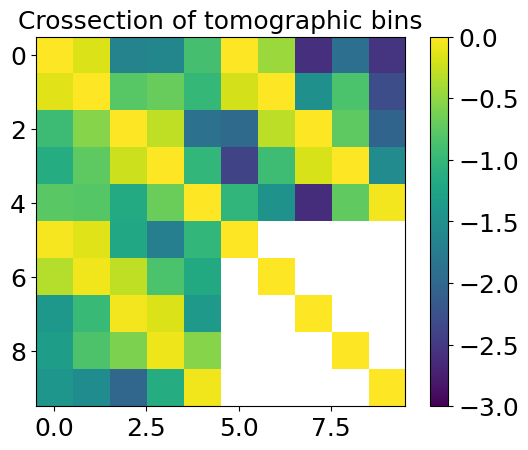

In [7]:
cross_sect = np.zeros((len(tomos), len(tomos)))
z = np.linspace(0, 3, 1000)
for i, (key1, tomo1) in enumerate(tomos.items()):
    for j, (key2, tomo2) in enumerate(tomos.items()):
            if key1.startswith("lens") and key2.startswith("lens") and i!=j:
                cross_sect[i, j] = np.nan
            else:
                if i >= j:
                    tomo1_z = tomo1["znodes"]
                    tomo2_z = tomo2["znodes"]
                    tomo1_photo_hists = tomo1["photo_hists"]
                    tomo2_photo_hists = tomo2["photo_hists"]
                    tomo1_mean = np.mean(tomo1_photo_hists, axis=1)
                    tomo2_mean = np.mean(tomo2_photo_hists, axis=1)
                    tomo1_mean /= np.sum(tomo1_mean)
                    tomo2_mean /= np.sum(tomo2_mean)
                    tomo1_mean = np.interp(z, tomo1_z, tomo1_mean)
                    tomo2_mean = np.interp(z, tomo2_z, tomo2_mean)
                    tomo1_mean /= np.sum(tomo1_mean)
                    tomo2_mean /= np.sum(tomo2_mean)
                    cross_sect[i, j] = np.trapz(tomo1_mean * tomo2_mean, z)
                else:
                    tomo1_z = ss_qp.tracers[key1].z
                    tomo2_z = ss_qp.tracers[key2].z
                    tomo1_mean = ss_qp.tracers[key1].nz
                    tomo2_mean = ss_qp.tracers[key2].nz
                    tomo1_mean /= np.sum(tomo1_mean)
                    tomo2_mean /= np.sum(tomo2_mean)
                    tomo1_mean = np.interp(z, tomo1_z, tomo1_mean)
                    tomo2_mean = np.interp(z, tomo2_z, tomo2_mean)
                    tomo1_mean /= np.sum(tomo1_mean)
                    tomo2_mean /= np.sum(tomo2_mean)
                    cross_sect[i, j] = np.trapz(tomo1_mean * tomo2_mean, z)
                
cross_sect_err = np.sqrt(np.diag(cross_sect))
cross_sect /= np.outer(cross_sect_err, cross_sect_err) 
plt.imshow(np.log10(cross_sect), cmap='viridis', vmin=-3, vmax=0)
plt.title('Crossection of tomographic bins')
plt.colorbar()

In [8]:
def make_nzs_plots(tracers_dict, tracer_list):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(tracer_list):
        nzs = tracers_dict[key].ensemble.objdata()['pdfs']
        nz_fid = tracers_dict[key].nz
        z = tracers_dict[key].z
        norms = np.sum(nzs, axis=1)
        nz_mean = np.mean(nzs, axis=0)
        axis[0,i].plot(z, (nzs.T/norms)[:, :100], '-', color='C0', alpha=0.1)
        axis[0,i].plot(z, nz_fid/np.sum(nz_fid), '--', color="k")
        axis[0,i].plot(z, nz_mean/np.sum(nz_mean), '-', color="k")
        cov = np.cov(nzs.T)
        err = np.sqrt(np.diag(cov))
        corr = cov/np.outer(err, err)
        nz_mean = np.mean(nzs, axis=1)
        axis[0,i].set_xlim([min(z), max(z)])
        axis[0,i].set_ylim([-0.001, 0.1])
        axis[0,i].set_title(key)
        if i == 0:
            axis[0,i].set_ylabel(r'$n(z)$')
        else:
            axis[0,i].set_yticklabels([])
            axis[1,i].set_yticklabels([])
        im = axis[1,i].imshow(corr, aspect='auto',
                            origin='lower', cmap='coolwarm',
                            vmin=-1, vmax=1,
                            extent=[min(z), max(z), max(z), min(z)])
        axis[1,i].set_xlabel(r'$z$')
        if i > 0:
            axis[1,i].set_yticklabels([])

    cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
    figure.colorbar(im, cax=cbar_ax)
    plt.show()

In [9]:
tracer_list = ss_qp.tracers.keys()
for key in tracer_list:
    nzs = ss_qp.tracers[key].ensemble.objdata()['pdfs']
    nzs = nzs.T/np.sum(nzs, axis=1)
    z = ss_qp.tracers[key].z
    file_name = f"{key}.npz"
    save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{}/".format(method) + file_name
    np.savez(save_to, z=z, photo_hists=nzs)

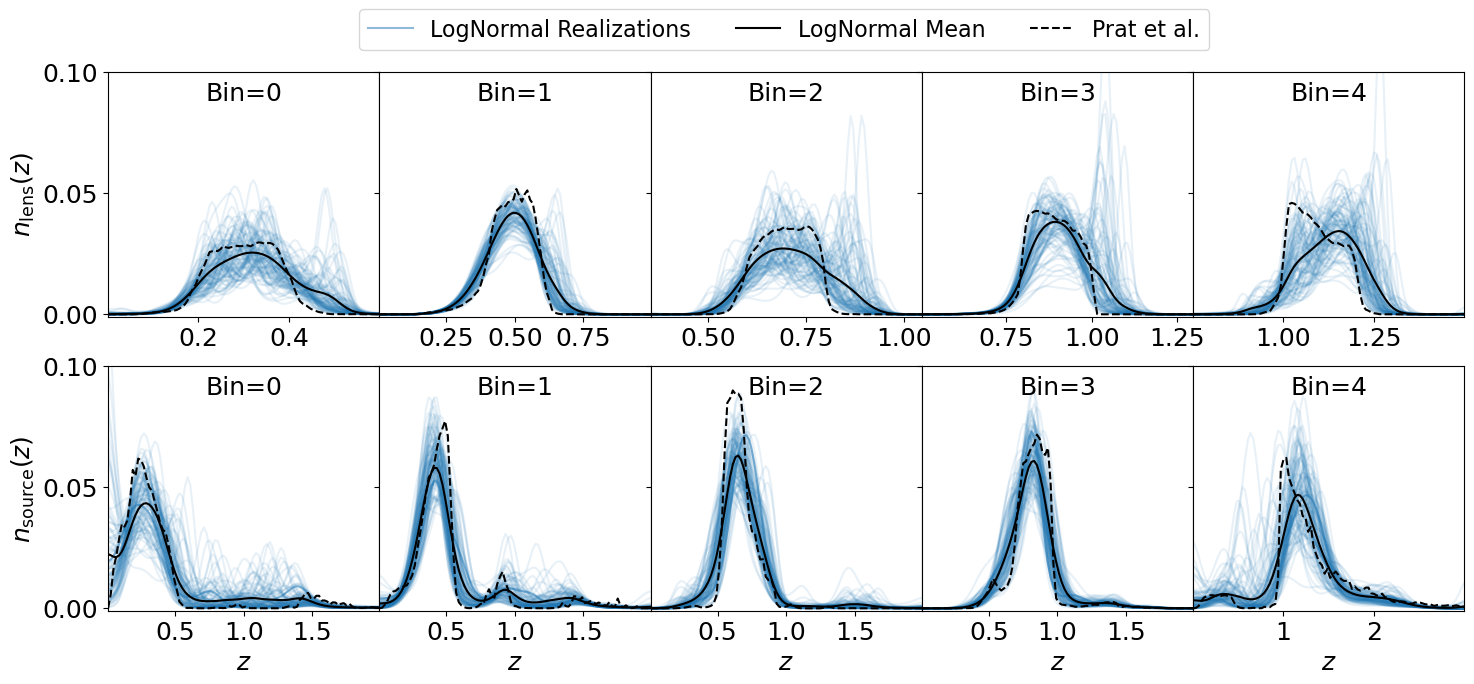

In [10]:
n_tracers = len(['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4'])
figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
figure.subplots_adjust(wspace=0, hspace=0.2)
for i, key in enumerate(['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']):
    nzs = ss_qp.tracers[key].ensemble.objdata()['pdfs']
    nz_fid = ss_qp.tracers[key].nz
    z = ss_qp.tracers[key].z
    norms = np.sum(nzs, axis=1)
    nz_mean = np.mean(nzs, axis=0)
    axis[0,i].plot(z, (nzs.T/norms)[:, :100], '-', color='C0', alpha=0.1)
    axis[0,i].plot(z, nz_fid/np.sum(nz_fid), '--', color="k")
    axis[0,i].plot(z, nz_mean/np.sum(nz_mean), '-', color="k")
    nz_mean = np.mean(nzs, axis=1)
    axis[0,i].set_xlim([min(z), max(z)])
    axis[0,i].set_ylim([-0.001, 0.1])
    axis[0,i].set_title(f"Bin={i}", y=0.85)
    if i == 0:
        axis[0,i].set_ylabel(r'$n_{\rm lens}(z)$')
    else:
        axis[0,i].set_yticklabels([])
        axis[1,i].set_yticklabels([])
    axis[1,i].set_xlabel(r'$z$')
    if i > 0:
        axis[1,i].set_yticklabels([])
for i, key in enumerate(['source_0', 'source_1', 'source_2', 'source_3', 'source_4']):
    nzs = ss_qp.tracers[key].ensemble.objdata()['pdfs']
    nz_fid = ss_qp.tracers[key].nz
    z = ss_qp.tracers[key].z
    norms = np.sum(nzs, axis=1)
    nz_mean = np.mean(nzs, axis=0)
    axis[1,i].plot(z, (nzs.T/norms)[:, :100], '-', color='C0', alpha=0.1)
    axis[1,i].plot(z, (nzs.T/norms)[:, :1], '-', color='C0', alpha=0.5, label='LogNormal Realizations')
    axis[1,i].plot(z, nz_mean/np.sum(nz_mean), '-', color="k", label='LogNormal Mean')
    axis[1,i].plot(z, nz_fid/np.sum(nz_fid), '--', color="k", label='Prat et al.')
    nz_mean = np.mean(nzs, axis=1)
    axis[1,i].set_xlim([min(z), max(z)])
    axis[1,i].set_ylim([-0.001, 0.1])
    axis[1,i].set_title(f"Bin={i}", y=0.85)
    if i == 0:
        axis[1,i].set_ylabel(r'$n_{\rm source}(z)$')
    else:
        axis[1,i].set_yticklabels([])
    axis[1,i].set_xlabel(r'$z$')
    if i > 0:
        axis[1,i].set_yticklabels([])
plt.legend(loc='upper right', ncols=3, fontsize=16, bbox_to_anchor=(.1, 2.5))
plt.show()
figure.savefig(f"/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/nz_{method}.png", bbox_inches='tight', dpi=300)

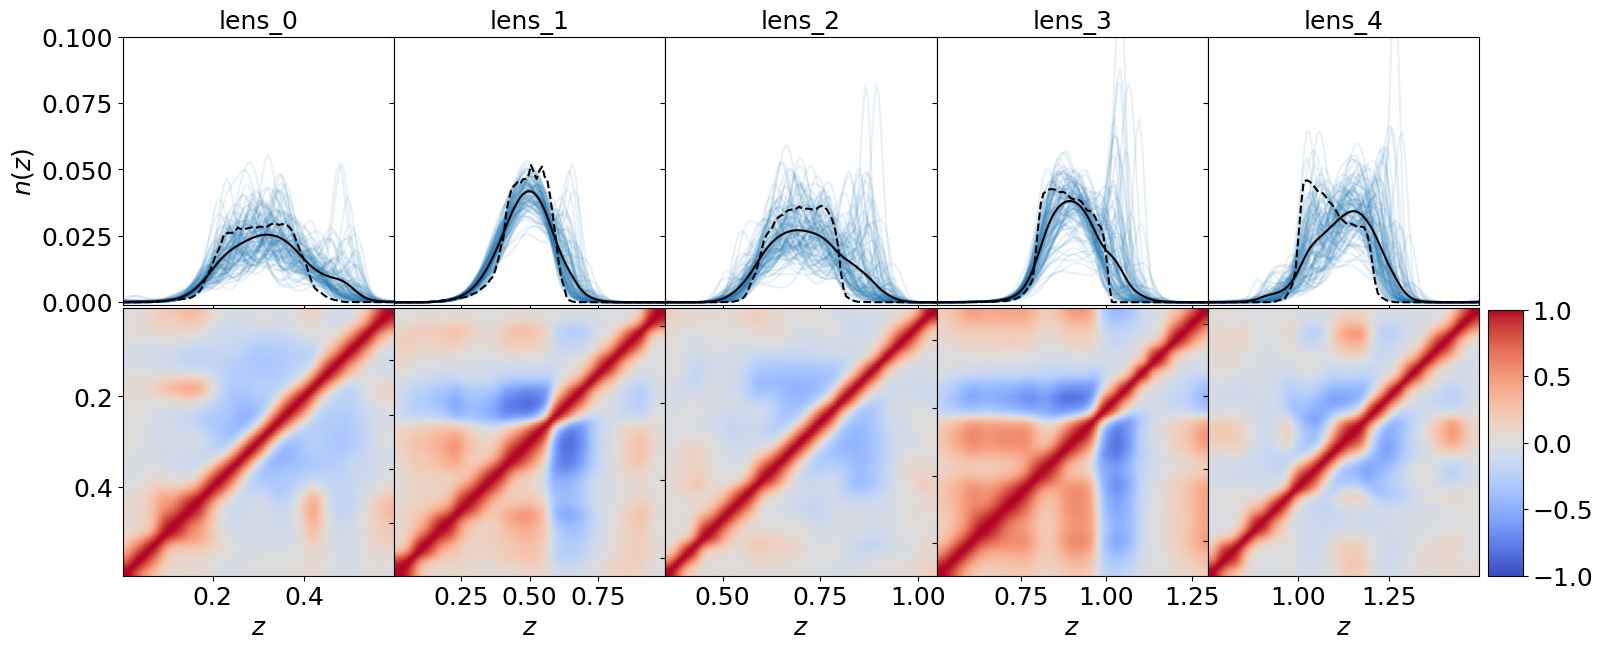

In [11]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(ss_qp.tracers, plot_tracers)

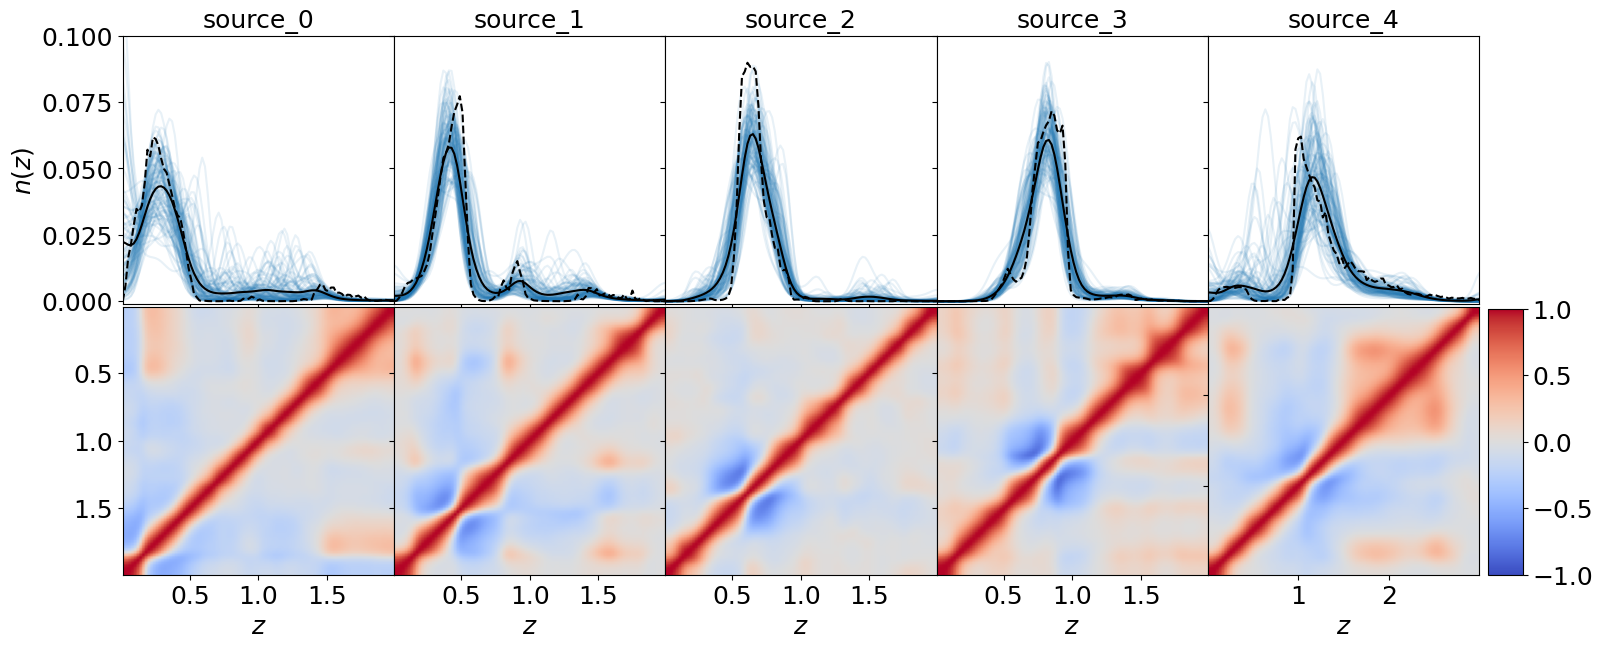

In [12]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(ss_qp.tracers, plot_tracers)

# Computing Uncertainties

Now we are just going to apply the methods of nz_prior described in the basic tutorial for each of the tracers in the sacc file. For the sake of brevity we will only use the qp tracers but the same can be done for the NZTracers.

## Shifts

In [13]:
shifts_priors = nzp.PriorSacc(ss_qp, 
                            model="Shifts",
                            compute_crosscorrs=crosscorrs_method)

Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4


In [14]:
labels = [
    r"\Delta z^{\rm source \, 0}",
    r"\Delta z^{\rm source \, 1}",
    r"\Delta z^{\rm source \, 2}",
    r"\Delta z^{\rm source \, 3}",
    r"\Delta z^{\rm source \, 4}",
    r"\Delta z^{\rm lens \, 0}",
    r"\Delta z^{\rm lens \, 1}",
    r"\Delta z^{\rm lens \, 2}",
    r"\Delta z^{\rm lens \, 3}",
    r"\Delta z^{\rm lens \, 4}"]

Removed no burn in
Removed no burn in


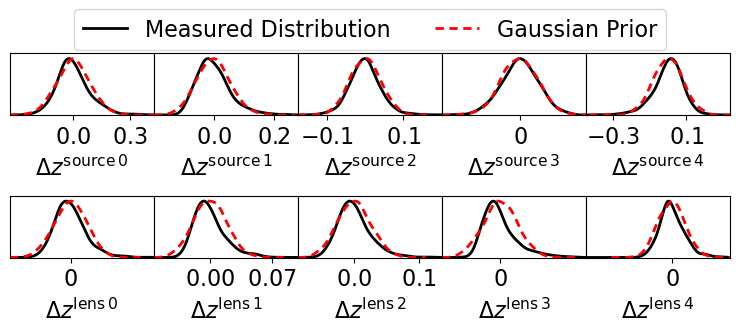

In [15]:
g = shifts_priors.plot_prior(mode="1D", add_prior=True, labels=labels, nx=5, legend_ncol=2, lws=2, ls=['-','--'])
g.export(f"/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/shifts_prior.pdf")

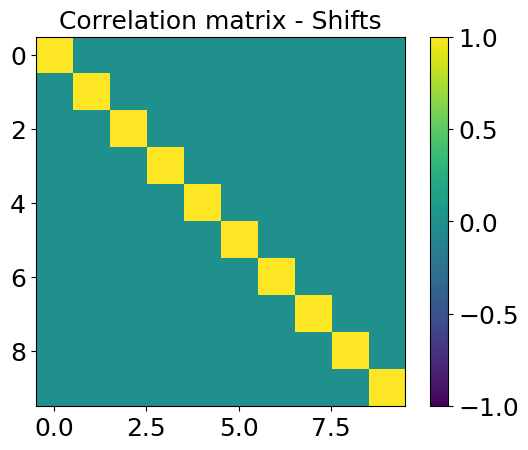

In [16]:
mean, cov, chol = shifts_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(corr, vmin=-1, vmax=1)
plt.title("Correlation matrix - Shifts")
plt.colorbar()

In [17]:
model_objs = shifts_priors.model_objs
for name in list(model_objs.keys()):
    model_obj = model_objs[name]
    z = model_obj.z
    mean = model_obj.nz_mean
    _, cov, chol = model_obj.get_prior()
    file_name = f"dz_{name}.npz"
    save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_dz_{}_priors/".format(method) + file_name
    np.savez(save_to, z=z, dndz=mean, cov=cov, chol=chol)

In [18]:
shifted_nzs = {}
for i in range(2000):
    prior_sample = shifts_priors.sample_prior()
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = shifts_priors.model_objs[tracer_name]
        z = model_obj.z
        nz =  model_obj.nz_mean
        param_names = model_obj.get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        s = [prior_sample[nz_name] for nz_name in nz_names]
        shifted_nz = nzp.shift_and_width_model(z, nz, s[0], 1)
        if i == 0:
            shifted_nzs[tracer_name] = [z, shifted_nz]
        else:

            shifted_nzs[tracer_name] = [z, np.vstack([shifted_nzs[tracer_name][1], shifted_nz])]


In [19]:
ss_qp_shifted = update_sacc_qp(ss_qp, shifted_nzs)

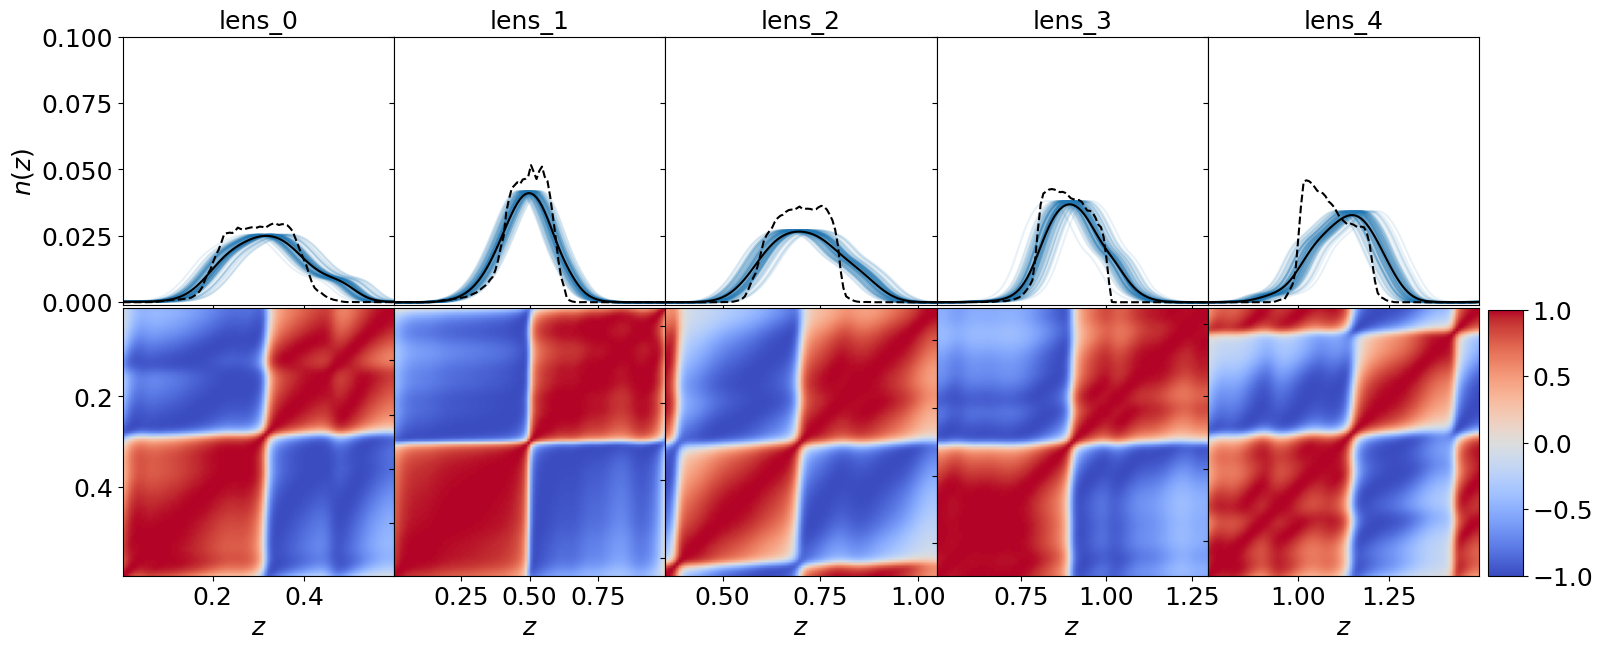

In [20]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(ss_qp_shifted.tracers, plot_tracers)

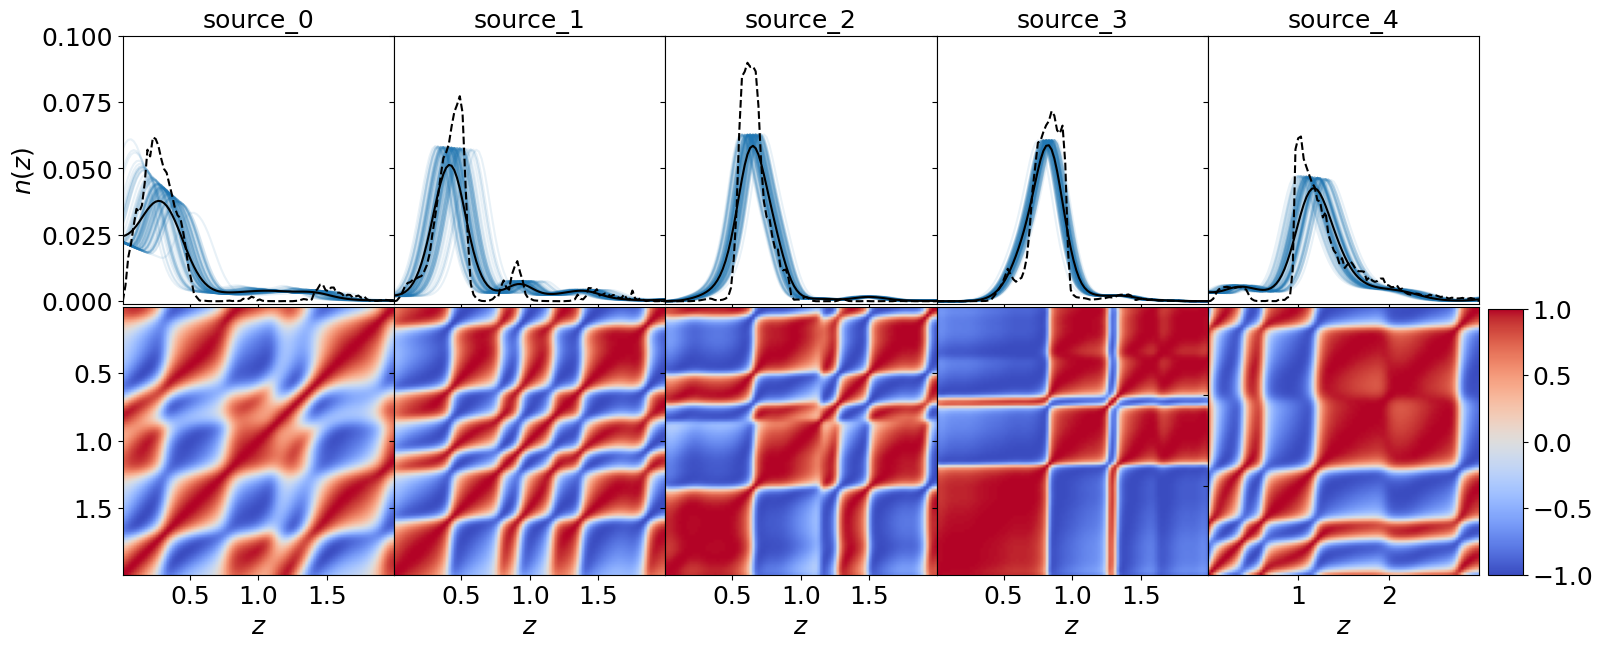

In [21]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(ss_qp_shifted.tracers, plot_tracers)

## Shifts & widths

In [22]:
SnWs_priors = nzp.PriorSacc(ss_qp, 
                            model="ShiftsWidths",
                            compute_crosscorrs=crosscorrs_method)

Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4


In [23]:
labels = np.array([
    r"\Delta z^{\rm source \, 0}",
    r"w_z^{\rm source \, 0}",
    r"\Delta z^{\rm source \, 1}",
    r"w_z^{\rm source \, 1}",
    r"\Delta z^{\rm source \, 2}",
    r"w_z^{\rm source \, 2}",
    r"\Delta z^{\rm source \, 3}",
    r"w_z^{\rm source \, 3}",
    r"\Delta z^{\rm source \, 4}",
    r"w_z^{\rm source \, 4}",
    r"\Delta z^{\rm lens \, 0}",
    r"w_z^{\rm lens \, 0}",
    r"\Delta z^{\rm lens \, 1}",
    r"w_z^{\rm lens \, 1}",
    r"\Delta z^{\rm lens \, 2}",
    r"w_z^{\rm lens \, 2}",
    r"\Delta z^{\rm lens \, 3}",
    r"w_z^{\rm lens \, 3}",
    r"\Delta z^{\rm lens \, 4}",
    r"w_z^{\rm lens \, 4}"
])

In [24]:
order = [0, 2, 4, 6, 8, 1, 3, 5, 7, 9,
        10, 12, 14, 16, 18, 11, 13, 15, 17, 19]

Order:  [0, 2, 4, 6, 8, 1, 3, 5, 7, 9, 10, 12, 14, 16, 18, 11, 13, 15, 17, 19]
Removed no burn in
Removed no burn in


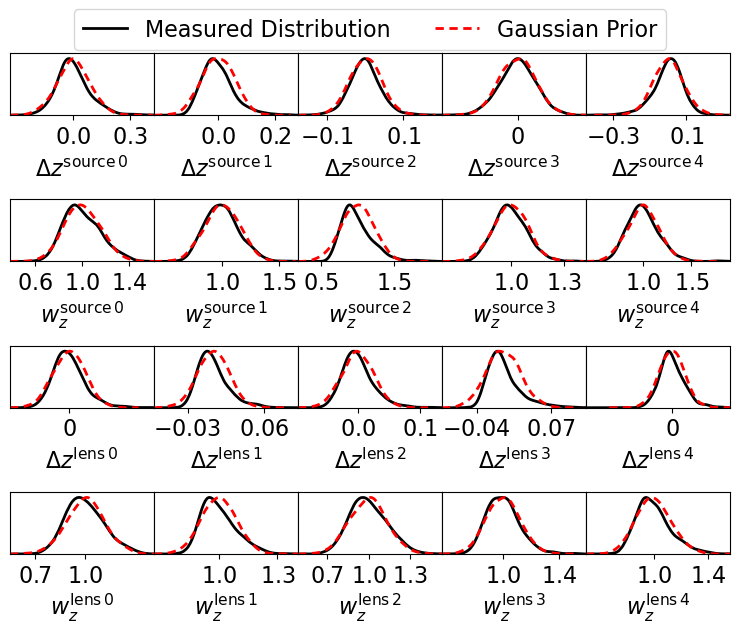

In [25]:
g = SnWs_priors.plot_prior(
    order=order,
    labels=labels, 
    mode="1D", 
    nx=5, 
    legend_ncol=2, 
    lws=2, 
    ls=['-','--'])
g.export("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/SnWs_prior.pdf")

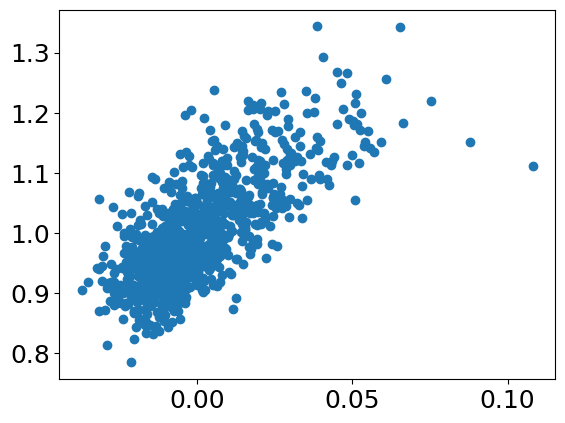

In [26]:
tomo_name = "lens_1"
plt.scatter(np.array(SnWs_priors.model_objs[tomo_name].shifts),
            np.array(SnWs_priors.model_objs[tomo_name].widths))

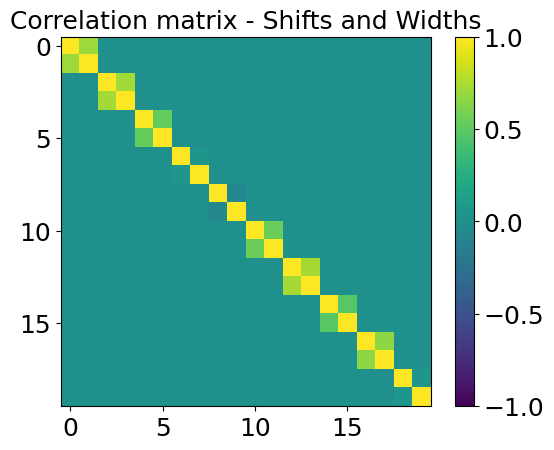

In [27]:
mean, cov, chol = SnWs_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(corr, vmin=-1, vmax=1)
plt.title("Correlation matrix - Shifts and Widths")
plt.colorbar()

In [28]:
model_objs = SnWs_priors.model_objs
for name in list(model_objs.keys()):
    model_obj = model_objs[name]
    z = model_obj.z
    mean = model_obj.nz_mean
    _, cov, chol = model_obj.get_prior()
    file_name = f"wzdz_{name}.npz"
    save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_wzdz_{}_priors/".format(method) + file_name
    np.savez(save_to, z=z, dndz=mean, cov=cov, chol=chol)

In [29]:
SnWs_nzs = {}
for i in range(2000):
    prior_sample = SnWs_priors.sample_prior()
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = SnWs_priors.model_objs[tracer_name]
        z = model_obj.z
        nz = model_obj.nz_mean
        param_names = model_obj.get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        s, w = [prior_sample[nz_name] for nz_name in nz_names]
        shifted_nz = nzp.shift_and_width_model(z, nz, s, w)
        if i == 0:
            SnWs_nzs[tracer_name] = [z, shifted_nz]
        else:

            SnWs_nzs[tracer_name] = [z, np.vstack([SnWs_nzs[tracer_name][1], shifted_nz])]

In [30]:
SnWs_ss_qp = update_sacc_qp(ss_qp, SnWs_nzs)

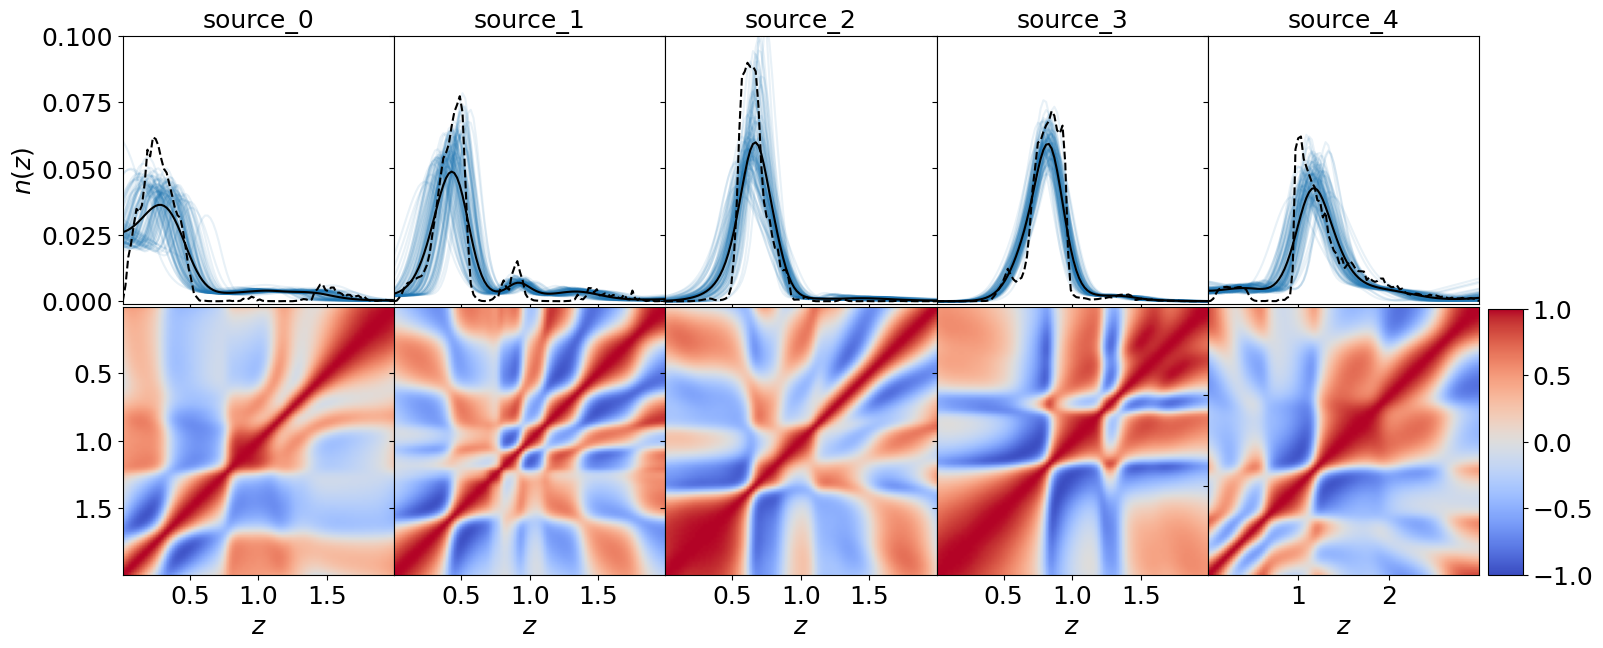

In [31]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(SnWs_ss_qp.tracers, plot_tracers)

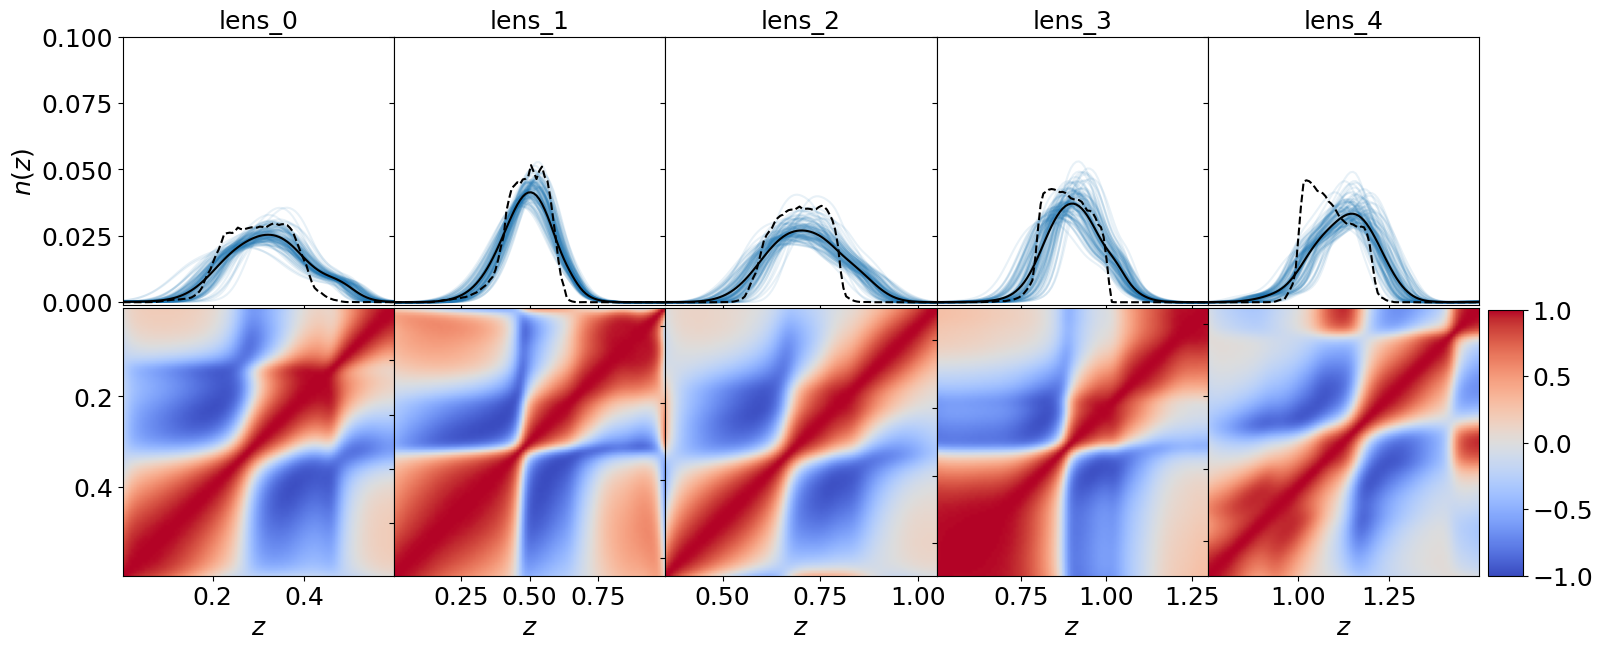

In [32]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(SnWs_ss_qp.tracers, plot_tracers)

## GP

In [366]:
n=10
gp_priors = nzp.PriorSacc(ss_qp,
                            model="GP",
                            compute_crosscorrs=crosscorrs_method,
                            n=n)

Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4


In [367]:
self = gp_priors.model_objs['source_1']
n1, m1 = self.Ws.shape
n2, m2 = self.nzs.shape
nzqs = np.zeros((n1, m2 + m1))
nzqs[:, :m2] = self.nzs
nzqs[:, m2:] = self.Ws
nzq_mean = np.mean(nzqs, axis=0)
dnzqs = nzqs - nzq_mean
cov_zzqq = np.cov(dnzqs.T)
cov_zz = cov_zzqq[:len(self.nz_mean), :len(self.nz_mean)]
cov_qq = cov_zzqq[len(self.nz_mean) :, len(self.nz_mean) :]
cov_zq = cov_zzqq[: len(self.nz_mean), len(self.nz_mean) :]
inv_cov_qq = np.linalg.pinv(cov_qq)
wiener = np.dot(cov_zq, inv_cov_qq)

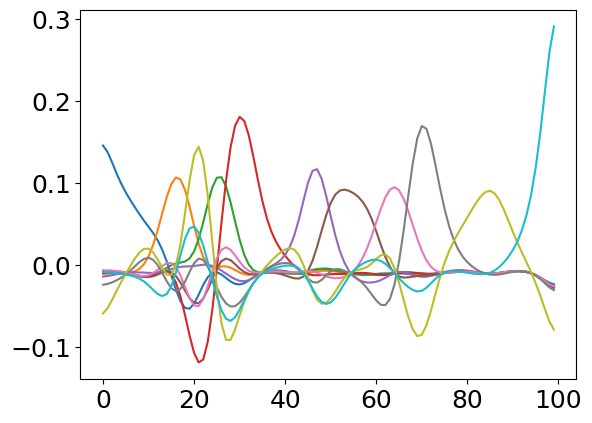

In [368]:
plt.plot(wiener);

The covariance matrix will be regularized
The covariance matrix will be regularized
The covariance matrix will be regularized
The covariance matrix will be regularized
The covariance matrix will be regularized


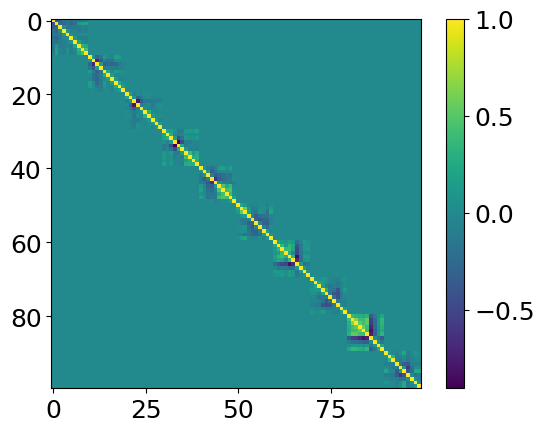

In [369]:
mean, cov, chol = gp_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(corr)
plt.colorbar()

In [370]:
labels = [
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm source \, 0}" for q in gp_priors.model_objs['source_0'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm source \, 1}" for q in gp_priors.model_objs['source_1'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm source \, 2}" for q in gp_priors.model_objs['source_2'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm source \, 3}" for q in gp_priors.model_objs['source_3'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm source \, 4}" for q in gp_priors.model_objs['source_4'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm lens \, 0}" for q in gp_priors.model_objs['lens_0'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm lens \, 1}" for q in gp_priors.model_objs['lens_1'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm lens \, 2}" for q in gp_priors.model_objs['lens_2'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm lens \, 3}" for q in gp_priors.model_objs['lens_3'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm lens \, 4}" for q in gp_priors.model_objs['lens_4'].q],
]
labels = np.array(labels).flatten()

In [371]:
#g = gp_priors.plot_prior(mode="1D", add_prior=True, labels=labels, nx=5, legend_ncol=2, lws=2, ls=['-','--'])
#g.export("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/gp_priors.pdf")

In [372]:
model_objs = gp_priors.model_objs
for name in list(model_objs.keys()):
    model_obj = model_objs[name]
    z = model_obj.z
    mean = model_obj.nz_mean
    _, _, chol = model_obj.get_prior()
    W = model_obj.funcs
    W = W @ chol
    file_name = f"gp_{name}.npz"
    save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_gp_{}_priors/".format(method) + file_name
    np.savez(save_to, z=z, dndz=mean, W=W)

In [373]:
gp_nzs = {}
for tracer_name in list(ss_qp.tracers.keys()):
    model_obj = gp_priors.model_objs[tracer_name]
    nz_mean = model_obj.nz_mean
    z = model_obj.z
    _, _, chol = model_obj.get_prior()
    W = model_obj.funcs
    W = W @ chol
    _nzs = np.array([nzp.linear_model(nz_mean, W, np.random.randn(n)) for i in range(2000)])
    gp_nzs[tracer_name] = [z, _nzs]

In [374]:
gp_ss_qp = update_sacc_qp(ss_qp, gp_nzs)

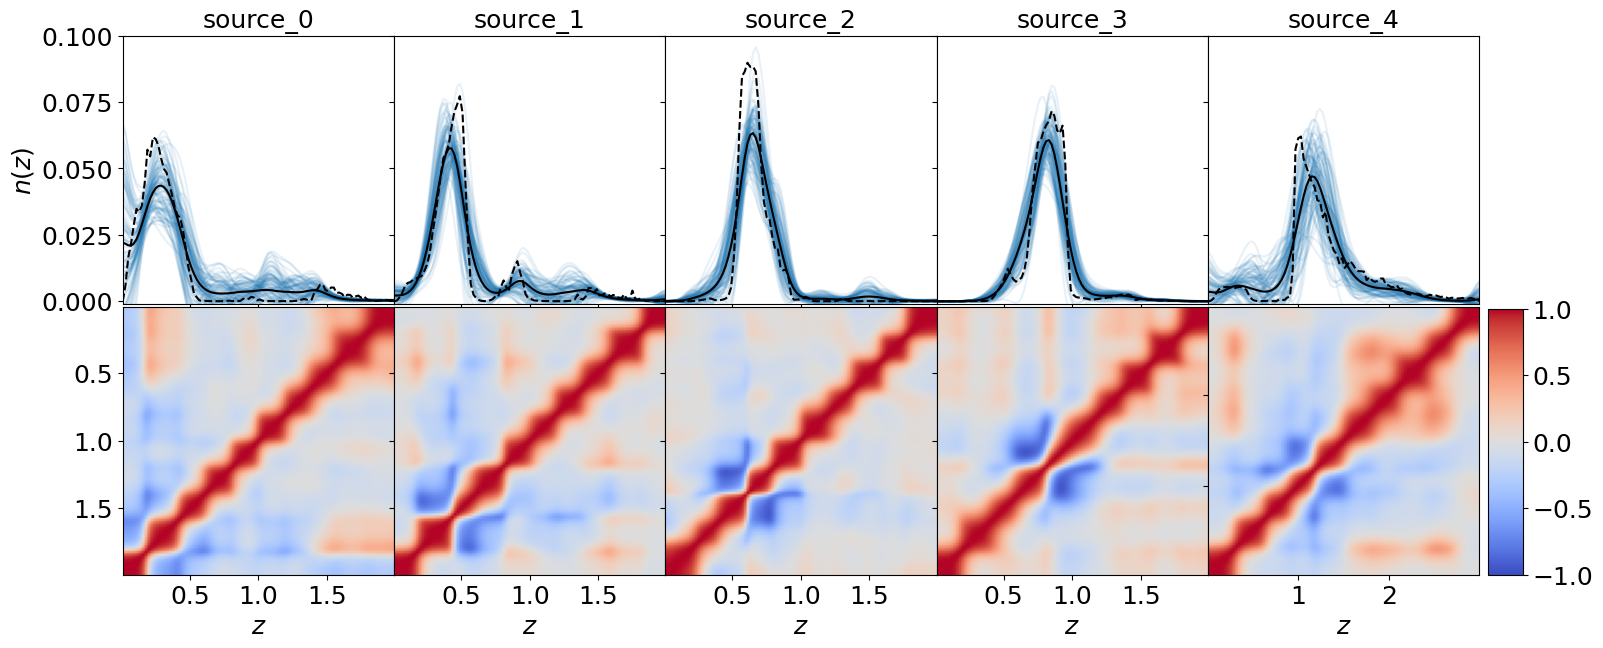

In [375]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(gp_ss_qp.tracers, plot_tracers)

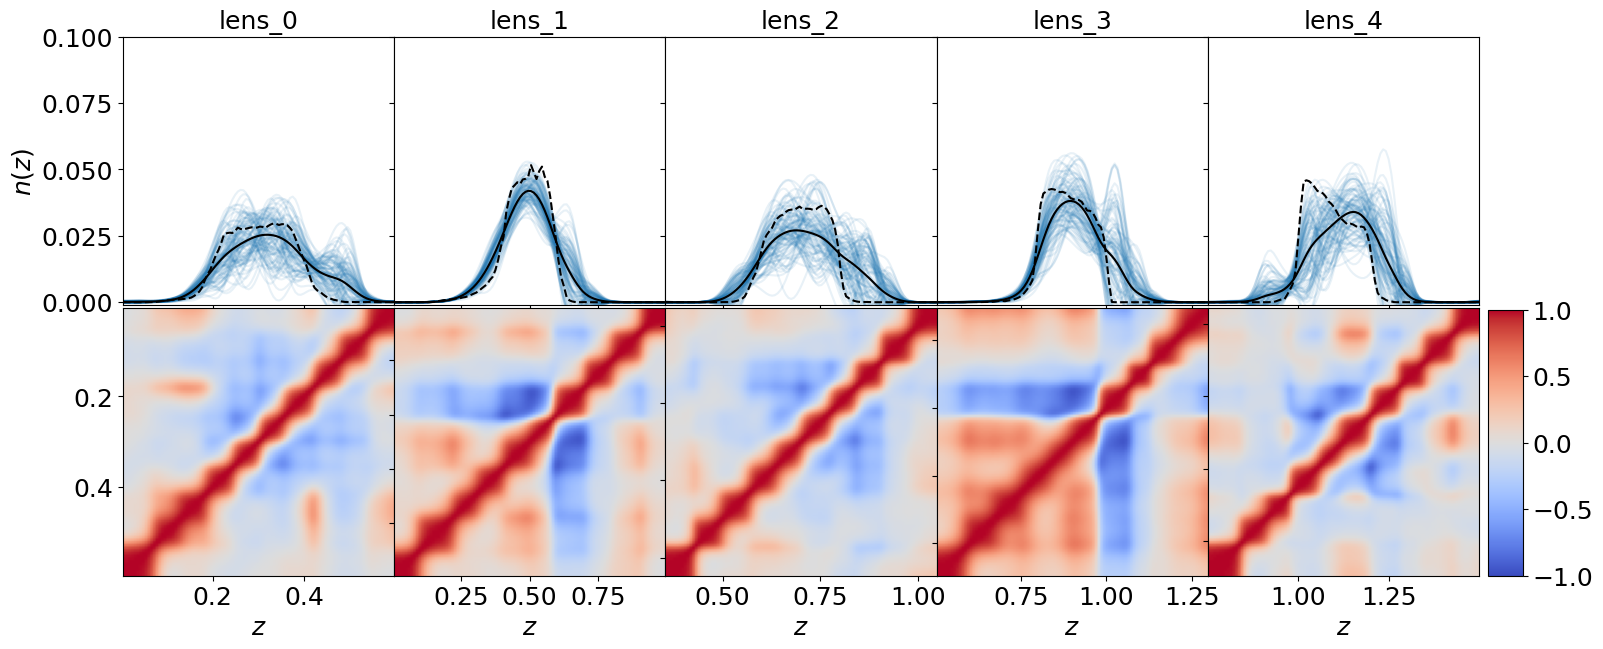

In [376]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(gp_ss_qp.tracers, plot_tracers)

# PCA

In [377]:
PCA_priors = nzp.PriorSacc(ss_qp,
                            model="PCA",
                            compute_crosscorrs=crosscorrs_method,
                            n=n)

Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4


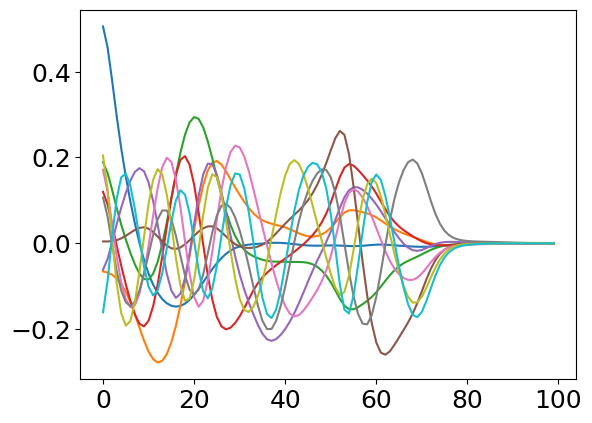

In [378]:
plt.plot(PCA_priors.model_objs['source_0'].funcs);

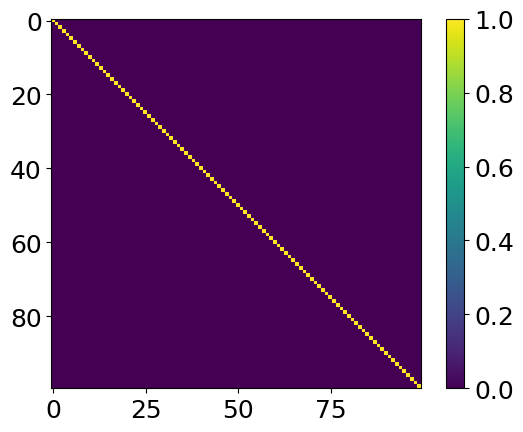

In [379]:
mean, cov, chol = PCA_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(np.sqrt(abs(corr)))
plt.colorbar()

In [380]:
labels = [
    r"\alpha_{1}^{\rm source \, 0}",
    r"\alpha_{2}^{\rm source \, 0}",
    r"\alpha_{3}^{\rm source \, 0}",
    r"\alpha_{4}^{\rm source \, 0}",
    r"\alpha_{5}^{\rm source \, 0}",
    r"\alpha_{1}^{\rm source \, 1}",
    r"\alpha_{2}^{\rm source \, 1}",
    r"\alpha_{3}^{\rm source \, 1}",
    r"\alpha_{4}^{\rm source \, 1}",
    r"\alpha_{5}^{\rm source \, 1}",
    r"\alpha_{1}^{\rm source \, 2}",
    r"\alpha_{2}^{\rm source \, 2}",
    r"\alpha_{3}^{\rm source \, 2}",
    r"\alpha_{4}^{\rm source \, 2}",
    r"\alpha_{5}^{\rm source \, 2}",
    r"\alpha_{1}^{\rm source \, 3}",
    r"\alpha_{2}^{\rm source \, 3}",
    r"\alpha_{3}^{\rm source \, 3}",
    r"\alpha_{4}^{\rm source \, 3}",
    r"\alpha_{5}^{\rm source \, 3}",
    r"\alpha_{1}^{\rm source \, 4}",
    r"\alpha_{2}^{\rm source \, 4}",
    r"\alpha_{3}^{\rm source \, 4}",
    r"\alpha_{4}^{\rm source \, 4}",
    r"\alpha_{5}^{\rm source \, 4}",
    r"\alpha_{1}^{\rm lens \, 0}",
    r"\alpha_{2}^{\rm lens \, 0}",
    r"\alpha_{3}^{\rm lens \, 0}",
    r"\alpha_{4}^{\rm lens \, 0}",
    r"\alpha_{5}^{\rm lens \, 0}",
    r"\alpha_{1}^{\rm lens \, 1}",
    r"\alpha_{2}^{\rm lens \, 1}",
    r"\alpha_{3}^{\rm lens \, 1}",
    r"\alpha_{4}^{\rm lens \, 1}",
    r"\alpha_{5}^{\rm lens \, 1}",
    r"\alpha_{1}^{\rm lens \, 2}",
    r"\alpha_{2}^{\rm lens \, 2}",
    r"\alpha_{3}^{\rm lens \, 2}",
    r"\alpha_{4}^{\rm lens \, 2}",
    r"\alpha_{5}^{\rm lens \, 2}",
    r"\alpha_{1}^{\rm lens \, 3}",
    r"\alpha_{2}^{\rm lens \, 3}",
    r"\alpha_{3}^{\rm lens \, 3}",
    r"\alpha_{4}^{\rm lens \, 3}",
    r"\alpha_{5}^{\rm lens \, 3}",
    r"\alpha_{1}^{\rm lens \, 4}",
    r"\alpha_{2}^{\rm lens \, 4}",
    r"\alpha_{3}^{\rm lens \, 4}",
    r"\alpha_{4}^{\rm lens \, 4}",
    r"\alpha_{5}^{\rm lens \, 4}",
]

In [381]:
#g = PCA_priors.plot_prior(mode="1D", add_prior=True, nx=5, labels=labels, legend_ncol=2, lws=2, ls=['-','--'])
#g.export("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/pca_priors.pdf")

In [382]:
model_objs = PCA_priors.model_objs
for name in list(model_objs.keys()):
    model_obj = model_objs[name]
    z = model_obj.z
    mean = model_obj.nz_mean
    _, _, chol = model_obj.get_prior()
    W = model_obj.funcs
    W = W @ chol
    file_name = f"PCA_{name}.npz"
    save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_PCA_{}_priors/".format(method) + file_name
    np.savez(save_to, z=z, dndz=mean, W=W)


In [383]:
pca_nzs = {}
for tracer_name in list(ss_qp.tracers.keys()):
    model_obj = PCA_priors.model_objs[tracer_name]
    nz_mean = model_obj.nz_mean
    _, _, chol = model_obj.get_prior()
    z = model_obj.z
    W = model_obj.funcs
    W = W @ chol
    _nzs = np.array([nzp.linear_model(nz_mean, W, np.random.randn(n)) for i in range(2000)])
    pca_nzs[tracer_name] = [z, _nzs]

In [384]:
pca_ss_qp = update_sacc_qp(ss_qp, pca_nzs)

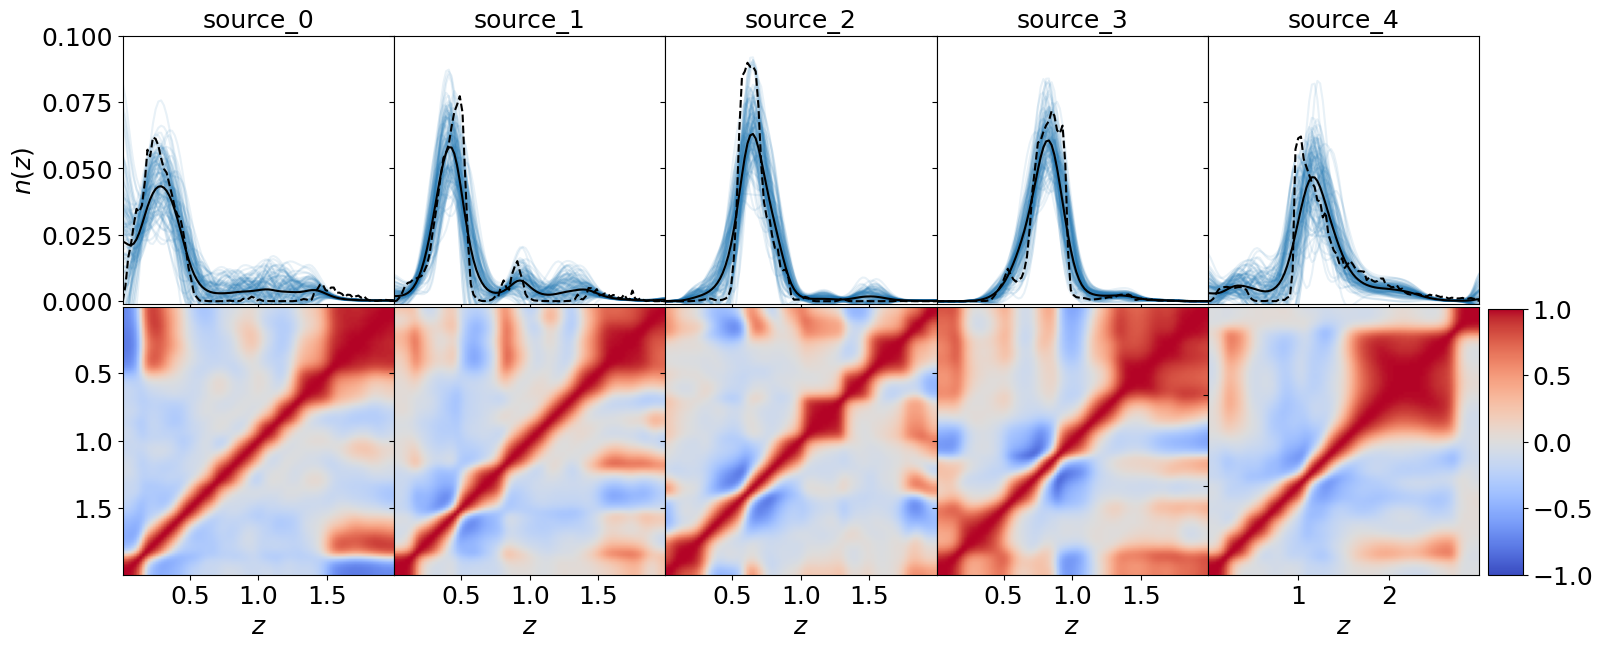

In [385]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(pca_ss_qp.tracers, plot_tracers)

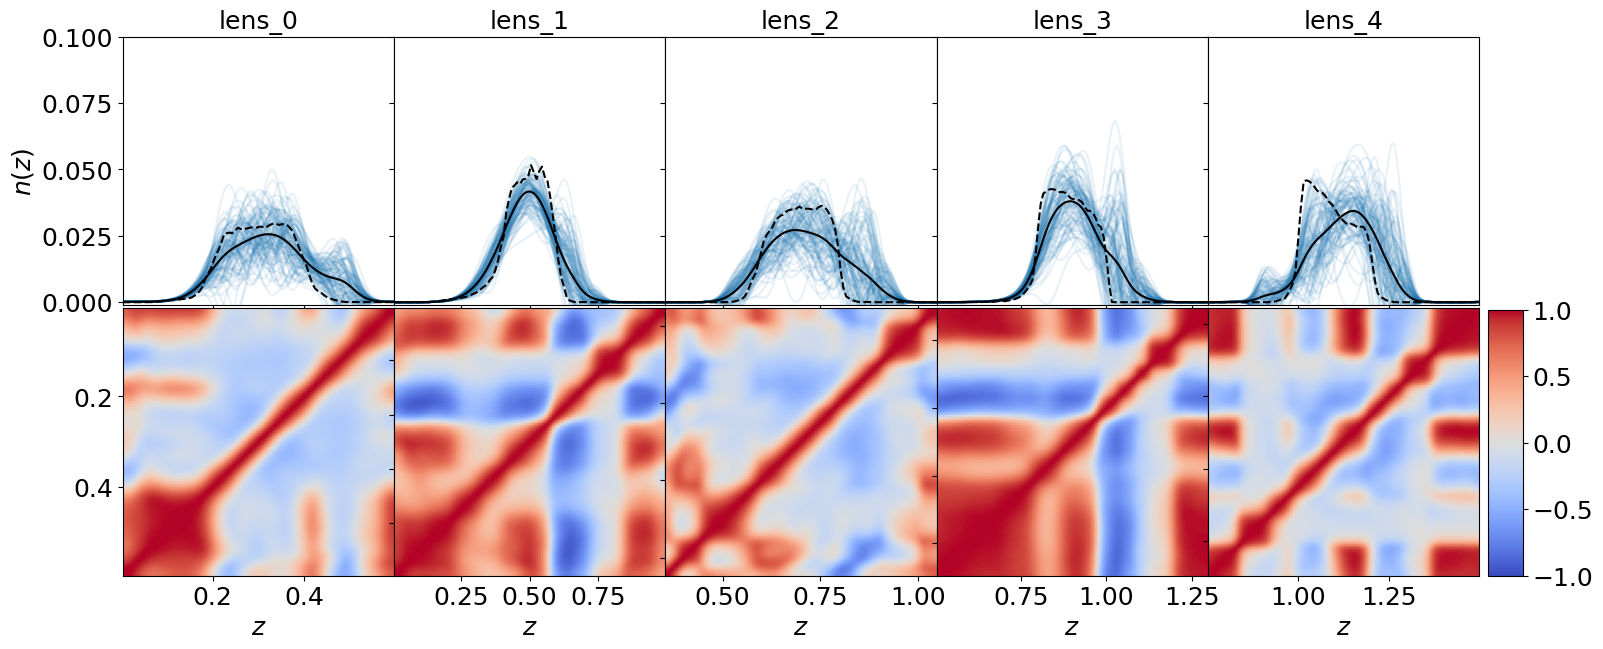

In [386]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(pca_ss_qp.tracers, plot_tracers)

# Comparison

In [387]:
def make_nzs_comp_plot(methods, tracer, sacc_file=None):
    n_tracers = len(methods)
    figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(methods):
        method = methods[key]
        tomo = method[tracer]
        if i !=0:
            nzs = tomo[1][:50].T
            zs = tomo[0]
        else:
            nzs = tomo.ensemble.objdata()["pdfs"][:50].T
            zs = tomo.z
        nz_mean = np.mean(nzs, axis=1)
        norms = np.sum(nzs, axis=0)
        axis[0,i].plot(zs, nz_mean/np.sum(nz_mean), '-', color="k")
        if sacc_file is not None:
            spec = sacc_file.tracers[tracer]
            photo_dz = np.mean(np.diff(zs))
            spec_dz = np.mean(np.diff(spec.z))
            alpha = photo_dz/spec_dz
            axis[0,i].plot(spec.z, alpha*spec.nz/np.sum(spec.nz), 'k--')
        axis[0,i].plot(zs, nzs/norms, '-', color="C0", alpha=0.1)
        cov = np.cov(nzs)
        err = np.sqrt(np.diag(cov))
        corr = cov/np.outer(err, err)
        axis[0,i].set_xlim([min(zs), max(zs)])
        axis[0,i].set_ylim([-0.001, 0.07])
        axis[0,i].set_title(key, y=0.9)
        if i == 0:
            axis[0,i].set_ylabel(r'$n_{\rm source \, 0}(z)$')
        else:
            axis[0,i].set_yticklabels([])
            axis[1,i].set_yticklabels([])
        im = axis[1,i].imshow(corr, aspect='auto',
                            origin='lower', cmap='coolwarm',
                             vmin=-1, vmax=1,
                            extent=[min(zs), max(zs), max(zs), min(zs)])
        axis[1,i].set_xlabel(r'$z$')

    cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
    figure.colorbar(im, cax=cbar_ax)
    plt.show()
    return figure

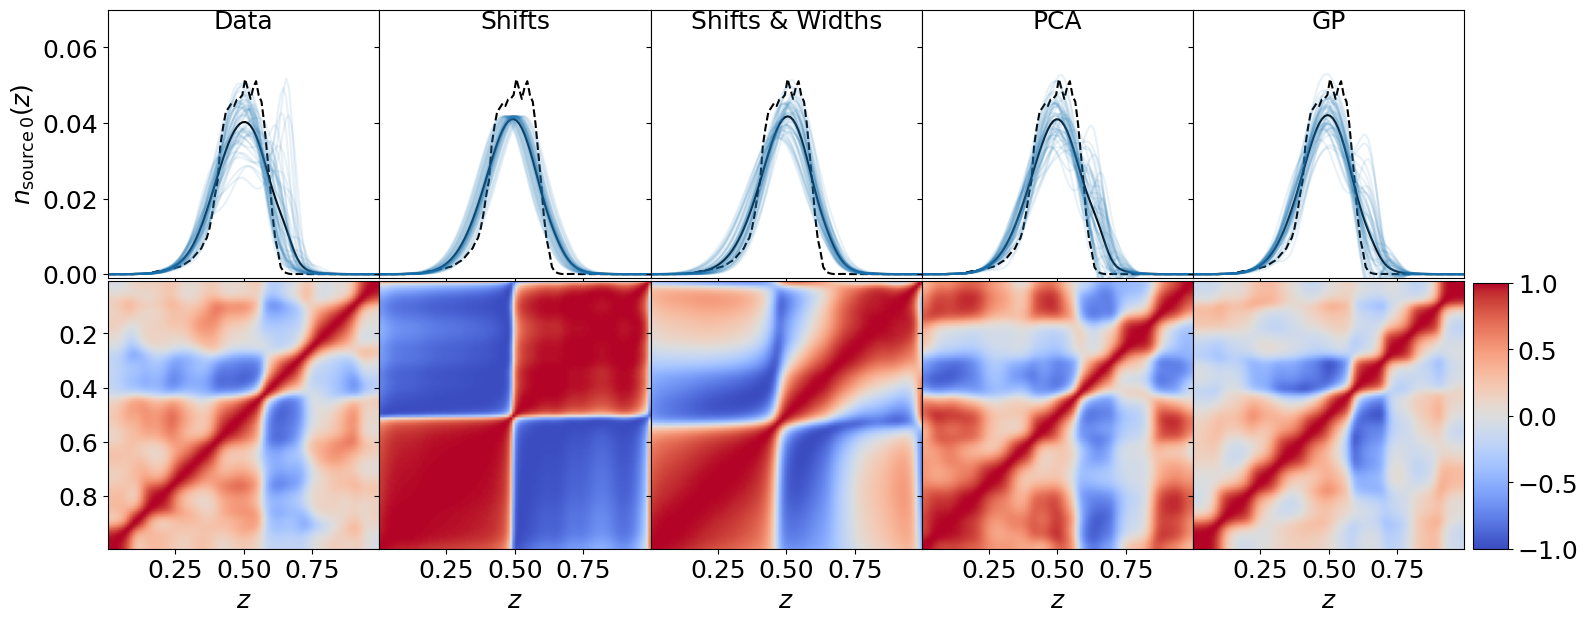

In [388]:
g = make_nzs_comp_plot({'Data': ss_qp.tracers, 'Shifts':shifted_nzs, 'Shifts & Widths':SnWs_nzs, 'PCA':pca_nzs, 'GP':gp_nzs}, 'lens_1', sacc_file=ss_qp)
g.savefig("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/source_0_validation.pdf", bbox_inches='tight')

In [389]:
def comp_diag(methods, tracers, sacc_file=None):
    n_tracers = len(tracers)
    figure, axis = plt.subplots(1, n_tracers, figsize=(n_tracers*5,5))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    errs = {}
    covs = {}
    for key in methods.keys():
        errs[key] = 0
        covs[key] = 0
    for i, tracer in enumerate(tracers):
        nzs = sacc_file.tracers[tracer].ensemble.objdata()["pdfs"].T
        nzs /= np.sum(nzs, axis=0)
        ref_cov = np.cov(nzs)
        ref_err = np.sqrt(np.diag(ref_cov))
        for j, key in enumerate(methods):
            method = methods[key]
            tomo = method[tracer]
            nzs = tomo[1].T
            zs = tomo[0]
            nzs /= np.sum(nzs, axis=0)
            cov = np.cov(nzs)
            err = np.sqrt(np.diag(cov))
            errs[key] += np.mean(np.abs(ref_err-err)/ref_err)
            covs[key] += np.mean(np.abs(np.abs(ref_cov)-np.abs(cov))/np.abs(ref_cov))
            axis[i].plot(zs, np.abs(err)/ref_err, '-', alpha=0.8)
        axis[i].plot(zs, np.ones_like(zs), 'k--', lw=1.5)
        axis[i].set_xlim([min(zs), max(zs)])
        axis[i].set_ylim([0.01, 20])
        axis[i].set_yscale('log')
        axis[i].set_title(tracer, y=0.9)
        if i == 0:
            axis[i].set_ylabel(r"$\sigma_{\rm nz}/\sigma_{\rm nz}^{\rm fid}$")
        else:
            axis[i].set_yticklabels([])
    plt.show()
    for key in errs.keys():
        print(key, errs[key]/len(tracers), covs[key]/len(tracers))
    return figure

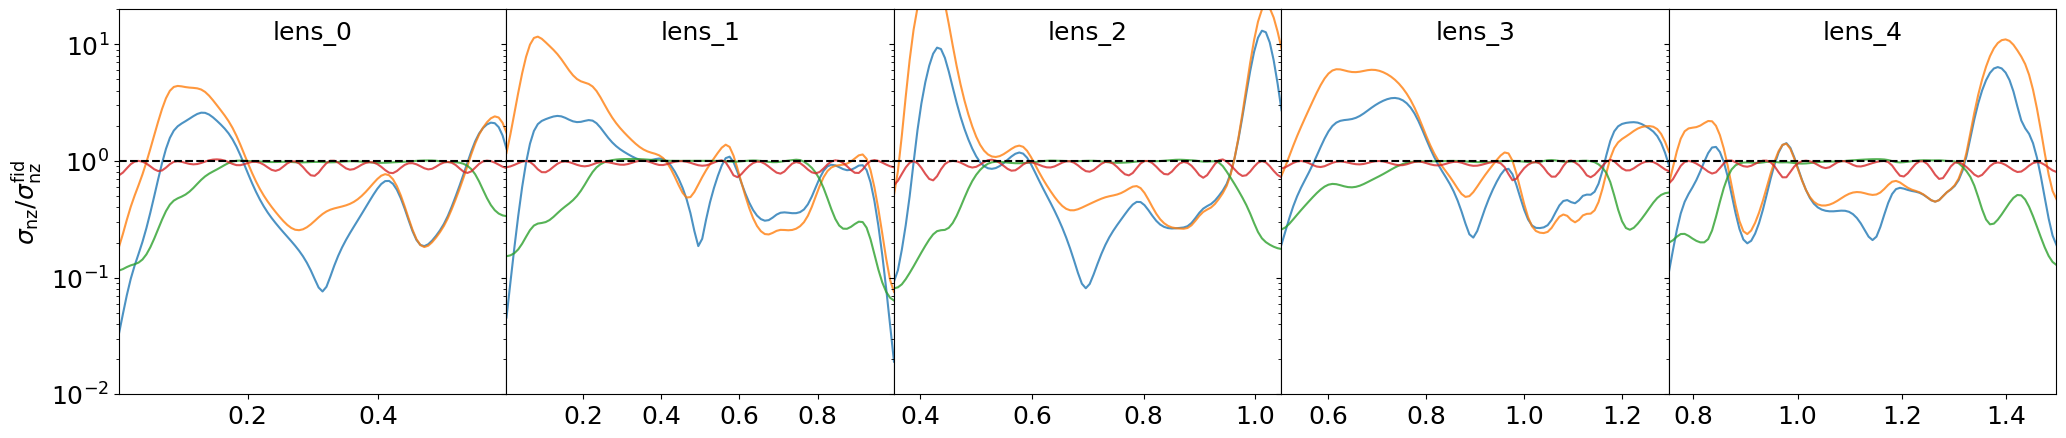

Shifts 0.9371765709608161 30.256529152386953
Shifts & Widths 2.0612992762359394 56.40644991389284
PCA 0.2593301265061679 0.9032939729621118
GP 0.09297374186025668 1.12155309943013


In [390]:
g = comp_diag({
    'Shifts':shifted_nzs,
    'Shifts & Widths':SnWs_nzs,
    'PCA':pca_nzs, 
    'GP':gp_nzs},
    ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4'],
    sacc_file=ss_qp)


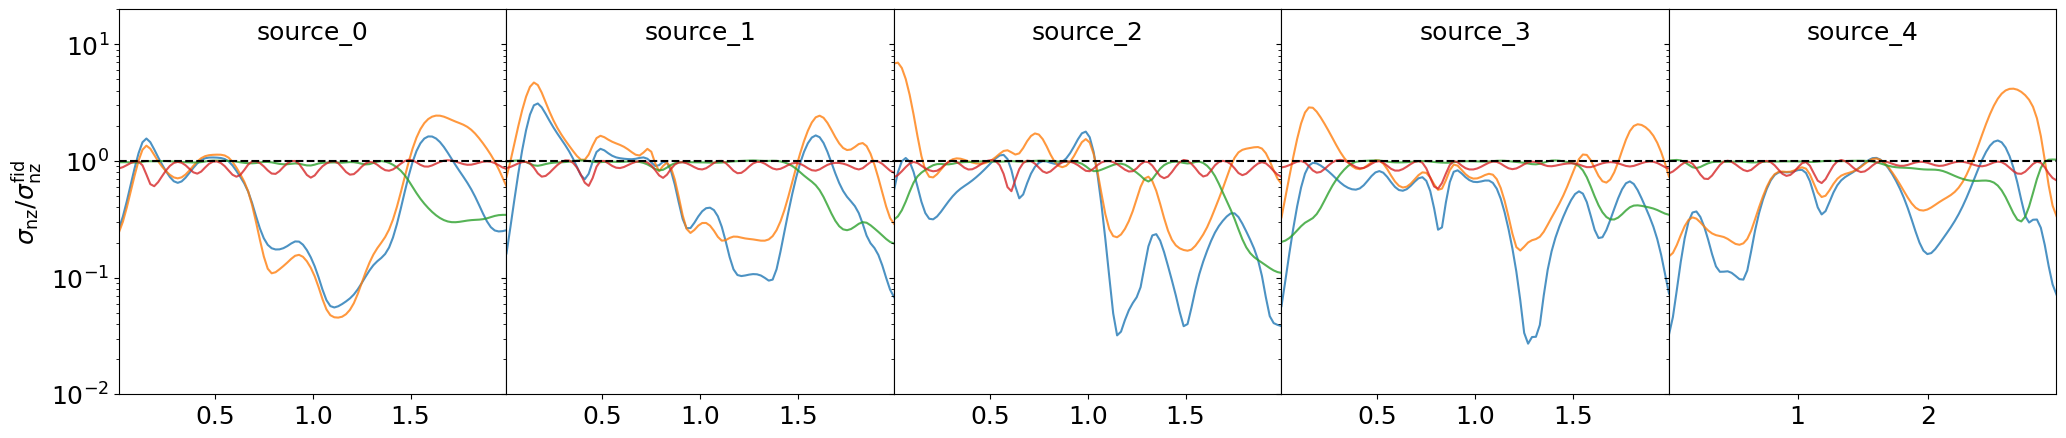

Shifts 0.5405861046201657 9.245615559163904
Shifts & Widths 0.6178361860690271 17.373296788177008
PCA 0.19323400348830871 1.519789473535036
GP 0.10423253038852476 1.2827924465082907


In [391]:
g = comp_diag({
    'Shifts':shifted_nzs,
    'Shifts & Widths':SnWs_nzs,
    'PCA':pca_nzs, 
    'GP':gp_nzs},
    ['source_0','source_1', 'source_2', 'source_3', 'source_4'],
    sacc_file=ss_qp)


In [392]:
def logdet(A, eps=1e-12):
    # Symmetrize to avoid numerical issues
    A = (A + A.T) / 2.0
    
    # Eigen-decomposition
    eigvals, eigvecs = np.linalg.eigh(A)
    
    # Clamp eigenvalues
    eigvals_clamped = np.clip(eigvals, eps, None)
    
    # Reconstruct positive definite matrix
    A_pd = eigvecs @ np.diag(eigvals_clamped) @ eigvecs.T
    
    # Cholesky decomposition
    L = np.linalg.cholesky(A_pd)
    
    # Log determinant = 2 * sum(log(diag(L)))
    logdet = 2.0 * np.sum(np.log(np.diag(L)))
    
    return logdet

def varsum(A, eps=1e-12):
    # Symmetrize to avoid numerical issues
    A = (A + A.T) / 2.0
    
    # Eigen-decomposition
    eigvals, eigvecs = np.linalg.eigh(A)
    
    # Clamp eigenvalues
    eigvals_clamped = np.clip(eigvals, eps, None)
    
    # Reconstruct positive definite matrix
    A_pd = eigvecs @ np.diag(eigvals_clamped) @ eigvecs.T
    
    varsum = np.sum(np.diag(A))
    
    return varsum

In [393]:
for key in ss_qp.tracers.keys():
    print(key,
          np.round(varsum(np.cov(ss_qp.tracers[key].ensemble.objdata()["pdfs"], rowvar=False)) / varsum(np.cov(shifted_nzs[key][1], rowvar=False)), 3),
          " & ",
          np.round(varsum(np.cov(ss_qp.tracers[key].ensemble.objdata()["pdfs"], rowvar=False)) / varsum(np.cov(SnWs_nzs[key][1], rowvar=False)), 3),
          " & ",
          np.round(varsum(np.cov(ss_qp.tracers[key].ensemble.objdata()["pdfs"], rowvar=False)) / varsum(np.cov(pca_nzs[key][1], rowvar=False)), 3),
          " & ",
          np.round(varsum(np.cov(ss_qp.tracers[key].ensemble.objdata()["pdfs"], rowvar=False)) / varsum(np.cov(gp_nzs[key][1], rowvar=False)), 3),
              r" \\\\"
          )
    print("\hline")

source_0 2.009  &  2.089  &  1.045  &  1.275  \\\\
\hline
source_1 0.855  &  0.539  &  1.029  &  1.251  \\\\
\hline
source_2 1.309  &  0.701  &  1.022  &  1.248  \\\\
\hline


<>:12: SyntaxWarning: invalid escape sequence '\h'
<>:12: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_55818/1076864889.py:12: SyntaxWarning: invalid escape sequence '\h'
  print("\hline")


source_3 2.5  &  1.859  &  1.03  &  1.348  \\\\
\hline
source_4 2.435  &  2.076  &  1.022  &  1.354  \\\\
\hline
lens_0 7.887  &  4.455  &  1.029  &  1.216  \\\\
\hline
lens_1 2.835  &  1.989  &  0.997  &  1.169  \\\\
\hline
lens_2 6.253  &  3.714  &  1.006  &  1.249  \\\\
\hline
lens_3 3.391  &  2.38  &  1.015  &  1.233  \\\\
\hline
lens_4 4.233  &  3.437  &  1.006  &  1.218  \\\\
\hline


In [ ]:
n=3
source_0 2.009  &  2.089  &  1.306  &  12.172  \\\\
\hline
source_1 0.855  &  0.539  &  1.256  &  6.13  \\\\
\hline
source_2 1.309  &  0.701  &  1.159  &  7.063  \\\\
\hline
source_3 2.5  &  1.859  &  1.083  &  4.823  \\\\
\hline
source_4 2.435  &  2.076  &  1.338  &  5.8  \\\\
\hline
lens_0 7.887  &  4.455  &  1.362  &  3.678  \\\\
\hline
lens_1 2.835  &  1.989  &  1.134  &  197.972  \\\\
\hline
lens_2 6.253  &  3.714  &  1.415  &  9.494  \\\\
\hline
lens_3 3.391  &  2.38  &  1.114  &  77.516  \\\\
\hline
lens_4 4.233  &  3.437  &  1.3  &  28.196  \\\\
\hline

n = 5
source_0 2.009  &  2.089  &  1.105  &  4.61  \\\\
\hline
source_1 0.855  &  0.539  &  1.149  &  1.843  \\\\
\hline
source_2 1.309  &  0.701  &  1.056  &  6.051  \\\\
\hline
source_3 2.5  &  1.859  &  0.988  &  1.74  \\\\
\hline
source_4 2.435  &  2.076  &  1.143  &  2.433  \\\\
\hline
lens_0 7.887  &  4.455  &  1.075  &  3.038  \\\\
\hline
lens_1 2.835  &  1.989  &  1.019  &  2.214  \\\\
\hline
lens_2 6.253  &  3.714  &  1.141  &  2.545  \\\\
\hline
lens_3 3.391  &  2.38  &  1.052  &  1.864  \\\\
\hline
lens_4 4.233  &  3.437  &  1.076  &  2.549  \\\\
\hline

n=10
source_0 2.009  &  2.089  &  1.045  &  1.275  \\\\
\hline
source_1 0.855  &  0.539  &  1.029  &  1.251  \\\\
\hline
source_2 1.309  &  0.701  &  1.022  &  1.248  \\\\
\hline
source_3 2.5  &  1.859  &  1.03  &  1.348  \\\\
\hline
source_4 2.435  &  2.076  &  1.022  &  1.354  \\\\
\hline
lens_0 7.887  &  4.455  &  1.029  &  1.216  \\\\
\hline
lens_1 2.835  &  1.989  &  0.997  &  1.169  \\\\
\hline
lens_2 6.253  &  3.714  &  1.006  &  1.249  \\\\
\hline
lens_3 3.391  &  2.38  &  1.015  &  1.233  \\\\
\hline
lens_4 4.233  &  3.437  &  1.006  &  1.218  \\\\
\hline

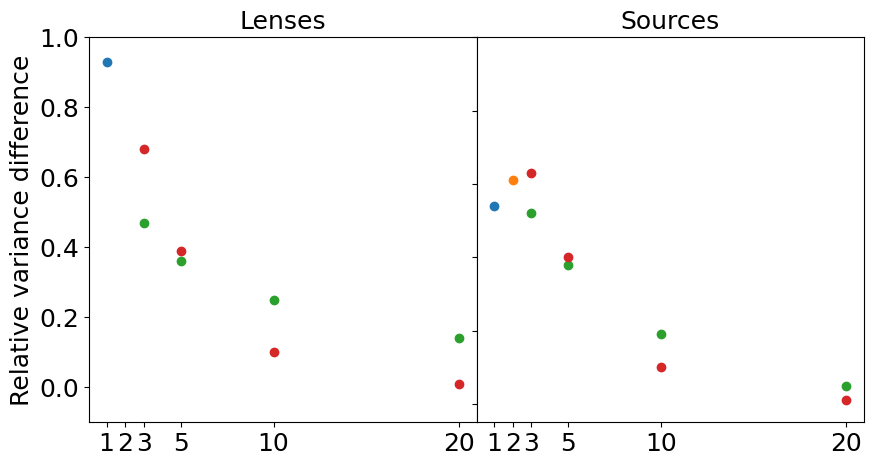

In [299]:
figure, axis = plt.subplots(1, 2, figsize=(10,5))
figure.subplots_adjust(wspace=0, hspace=0.01)
axis[0].plot([1], [0.93], 'o', color='C0')
axis[0].plot([2], [2.06], 'o', color='C1')
axis[0].plot([3], [0.47], 'o', color='C2')
axis[0].plot([3], [0.68], 'o', color='C3')
axis[0].plot([5], [0.36], 'o', color='C2')
axis[0].plot([5], [0.39], 'o', color='C3')
axis[0].plot([10], [0.25], 'o', color='C2')
axis[0].plot([10], [0.10], 'o', color='C3')
axis[0].plot([20], [0.14], 'o', color='C2')
axis[0].plot([20], [0.01], 'o', color='C3')
axis[0].set_ylabel("Relative variance difference")
axis[0].set_xticks([1,2,3,5,10,20])
axis[0].set_ylim([-0.1, 1])
axis[0].set_title("Lenses")


axis[1].plot([1], [0.54], 'o', color='C0')
axis[1].plot([2], [0.61], 'o', color='C1')
axis[1].plot([3], [0.52], 'o', color='C2')
axis[1].plot([3], [0.63], 'o', color='C3')
axis[1].plot([5], [0.38], 'o', color='C2')
axis[1].plot([5], [0.40], 'o', color='C3')
axis[1].plot([10], [0.19], 'o', color='C2')
axis[1].plot([10], [0.10], 'o', color='C3')
axis[1].plot([20], [0.05], 'o', color='C2')
axis[1].plot([20], [0.01], 'o', color='C3')
axis[1].set_xticks([1,2,3,5,10,20])
axis[1].set_ylim([-0.05, 1])
axis[1].set_title("Sources")
axis[1].set_yticklabels([])
plt.show()

In [153]:
def comp_eig(methods, tracers, sacc_file=None):
    n_tracers = len(tracers)
    figure, axis = plt.subplots(1, n_tracers, figsize=(n_tracers*3.5,5))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, tracer in enumerate(tracers):
        for j, key in enumerate(methods):
            method = methods[key]
            tomo = method[tracer]
            if j !=0:
                nzs = tomo[1].T
                zs = tomo[0]
            else:
                nzs = tomo.ensemble.objdata()["pdfs"].T
                zs = tomo.z
            nzs /= np.sum(nzs, axis=0)
            cov = np.cov(nzs)
            eigvals, _ = np.linalg.eig(cov)
            axis[i].plot(eigvals, '-', alpha=0.8)
            axis[i].set_ylim([1e-12, 1e2])
            axis[i].set_yscale('log')
            axis[i].set_title(tracer, y=0.9)
    plt.show()
    return figure

/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


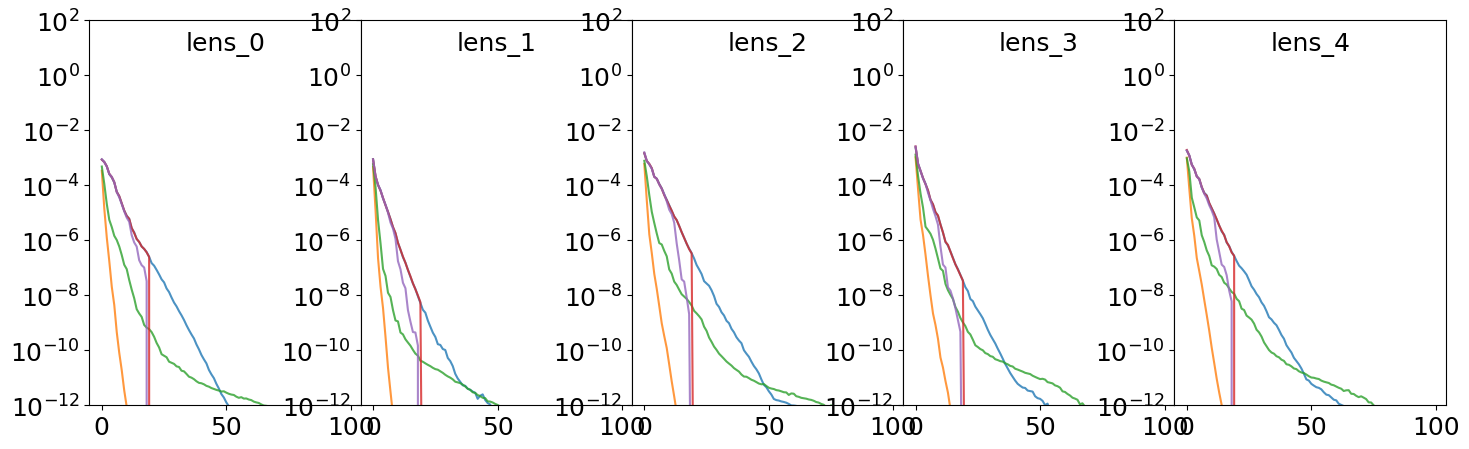

In [154]:
g = comp_eig({
    'Data': ss_qp.tracers,
    'Shifts':shifted_nzs,
    'Shifts & Widths':SnWs_nzs,
    'PCA':pca_nzs, 
    'GP':gp_nzs},
    ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4'],)


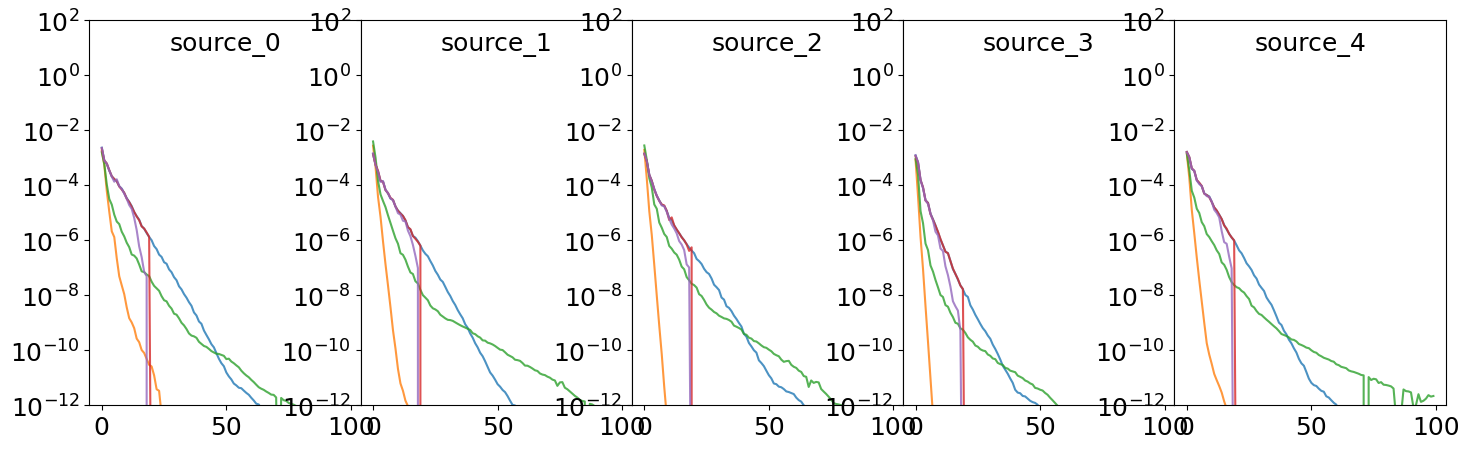

In [155]:
g = comp_eig({
    'Data': ss_qp.tracers,
    'Shifts':shifted_nzs,
    'Shifts & Widths':SnWs_nzs,
    'PCA':pca_nzs, 
    'GP':gp_nzs},
    ['source_0','source_1', 'source_2', 'source_3', 'source_4'])
